Loading data...
  Processing historical...
  Processing ssp126...
  Processing ssp245...
  Processing ssp585...
  Processing g6sulfur...
Data loading complete!


/tmp/ipykernel_72405/2371825773.py:197: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.05, 1.0, 1.0], h_pad=1.0, w_pad=0.5)



Figure saved to: ../Figures/fig5_01.png


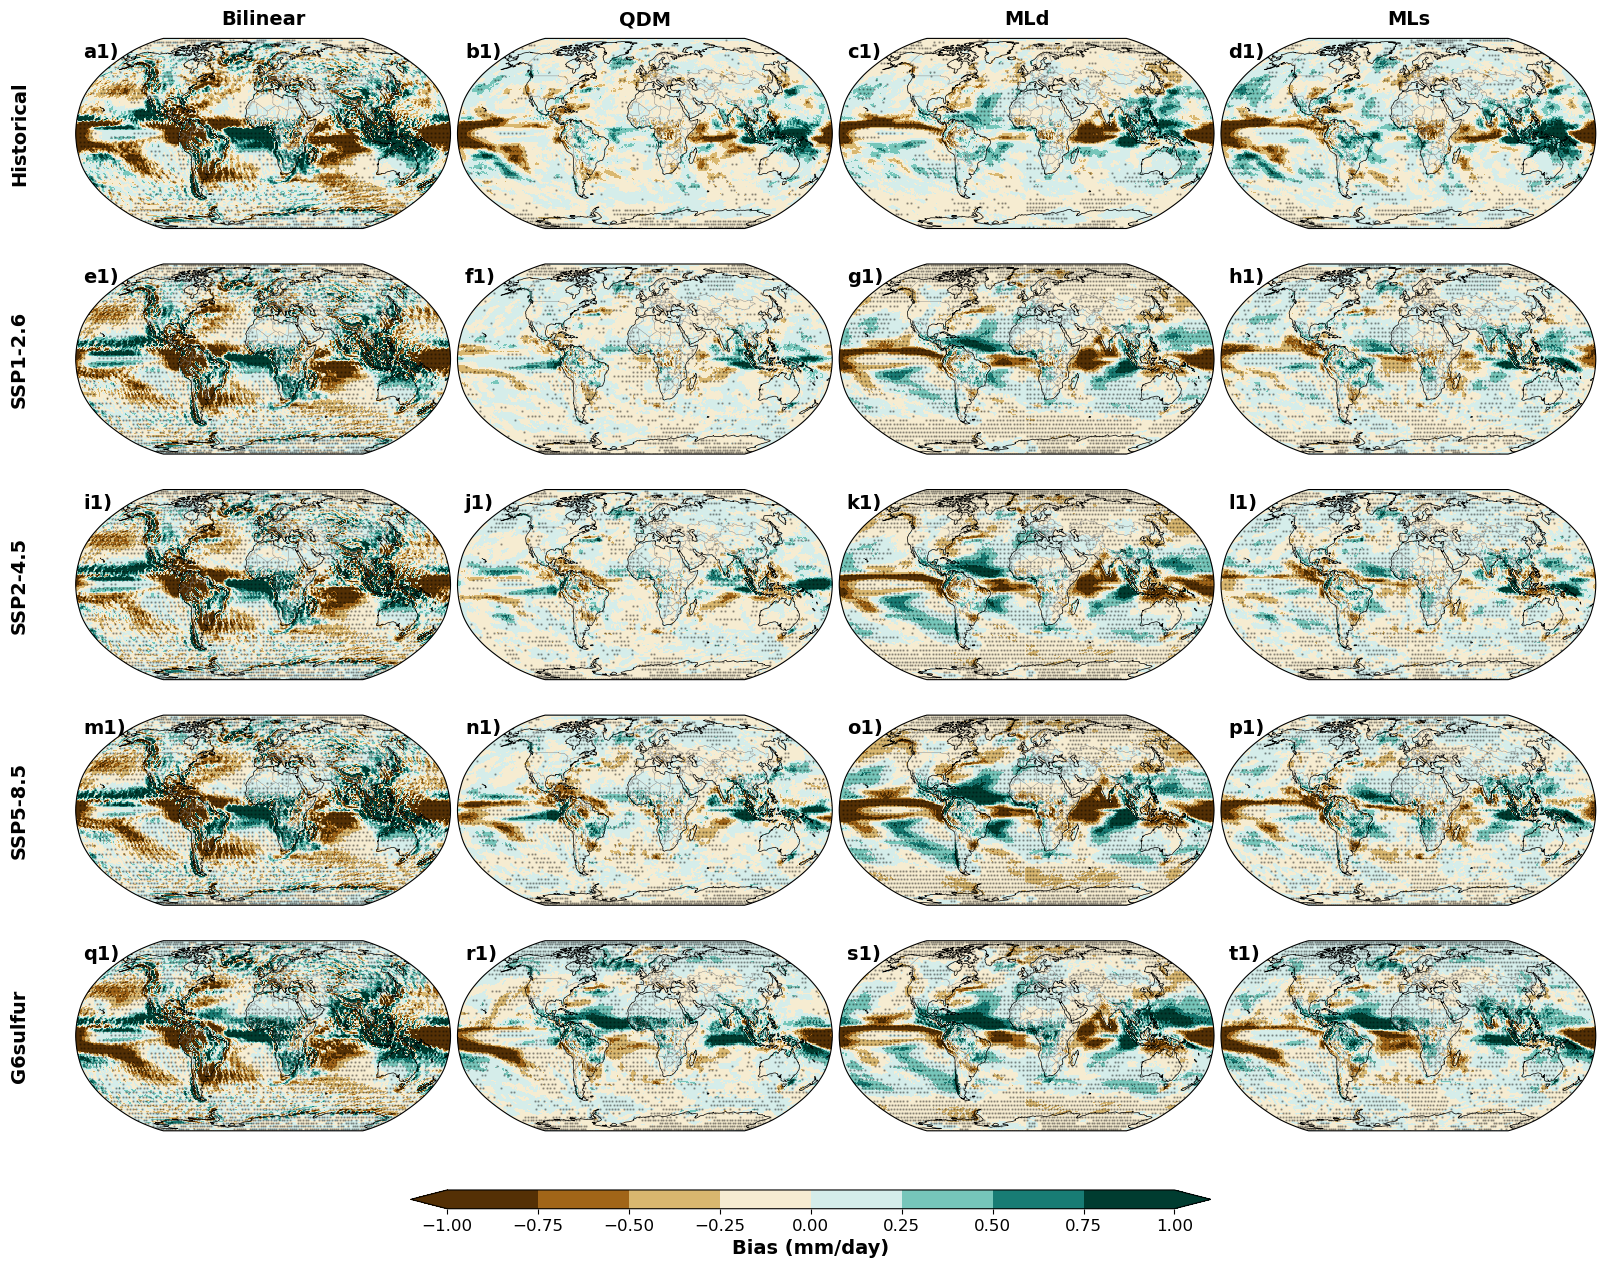

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm
from scipy import stats

# ----------------------------
# Configuration
# ----------------------------
results_dir = Path("../evaluation_results")
results_residual_dir = Path("../evaluation_results_residual")
figures_dir = Path("../Figures")

var_name = 'pr'  
scenarios = ['historical', 'ssp126', 'ssp245', 'ssp585', 'g6sulfur'] 
scenario_labels = {
    'historical': 'Historical',  
    'ssp126': 'SSP1-2.6',
    'ssp245': 'SSP2-4.5',
    'ssp585': 'SSP5-8.5',
    'g6sulfur': 'G6sulfur'
}

# Model configuration
models = ['bilinear', 'qdm', 'mld', 'mls']
model_labels = {
    'bilinear': 'Bilinear',
    'qdm': 'QDM',
    'mld': 'MLd',
    'mls': 'MLs'
}

# Significance level
alpha = 0.05  # 95% confidence level

# ----------------------------
# Functions
# ----------------------------
def calculate_mean_bias(pred_data, truth_data):
    """Calculate mean bias (prediction - truth) over all time steps."""
    bias = pred_data - truth_data
    mean_bias = np.mean(bias, axis=0)
    return mean_bias

def calculate_significance(pred_data, truth_data, alpha=0.05):
    """
    Calculate statistical significance of bias using t-test.
    Returns a boolean mask where True indicates significant bias.
    """
    # Calculate bias for each time step
    bias = pred_data - truth_data  # shape: (time, lat, lon)
    
    # Perform one-sample t-test at each grid point
    # H0: mean bias = 0
    t_stat, p_values = stats.ttest_1samp(bias, 0, axis=0)
    
    # Significant where p-value < alpha
    significant = p_values < alpha
    
    return significant

# ----------------------------
# Load data and calculate biases
# ----------------------------
print("Loading data...")
biases = {scenario: {} for scenario in scenarios}
significance = {scenario: {} for scenario in scenarios}
lat, lon = None, None

for scenario in scenarios:
    print(f"  Processing {scenario}...")
    
    # Load main results (for groundtruth, bilinear, MLd)
    main_file = results_dir / f"{var_name}_evaluation_{scenario}.nc"
    ds_main = xr.open_dataset(main_file)
    
    truth = ds_main['groundtruth'].values
    
    if lat is None:
        lat = ds_main.lat.values
        lon = ds_main.lon.values
    
    # Bilinear bias
    if 'input' in ds_main:
        biases[scenario]['bilinear'] = calculate_mean_bias(ds_main['input'].values, truth)
        significance[scenario]['bilinear'] = calculate_significance(ds_main['input'].values, truth, alpha)
    
    # MLd bias (zscore_pixel)
    if 'pred_zscore_pixel' in ds_main:
        biases[scenario]['mld'] = calculate_mean_bias(ds_main['pred_zscore_pixel'].values, truth)
        significance[scenario]['mld'] = calculate_significance(ds_main['pred_zscore_pixel'].values, truth, alpha)
    
    ds_main.close()
    
    # Load QDM results
    qdm_file = results_dir / f"{var_name}_evaluation_{scenario}_qdm.nc"
    if qdm_file.exists():
        ds_qdm = xr.open_dataset(qdm_file)
        
        if 'pred_qdm' in ds_qdm:
            truth_qdm = ds_qdm['groundtruth'].values
            biases[scenario]['qdm'] = calculate_mean_bias(ds_qdm['pred_qdm'].values, truth_qdm)
            significance[scenario]['qdm'] = calculate_significance(ds_qdm['pred_qdm'].values, truth_qdm, alpha)
        
        ds_qdm.close()
    
    # Load residual results (for MLs)
    residual_file = results_residual_dir / f"{var_name}_evaluation_{scenario}.nc"
    if residual_file.exists():
        ds_residual = xr.open_dataset(residual_file)
        
        if 'pred_grid' in ds_residual:
            truth_res = ds_residual['groundtruth'].values
            biases[scenario]['mls'] = calculate_mean_bias(ds_residual['pred_grid'].values, truth_res)
            significance[scenario]['mls'] = calculate_significance(ds_residual['pred_grid'].values, truth_res, alpha)
        
        ds_residual.close()

print("Data loading complete!")

# ----------------------------
# Create 5x4 subplot figure 
# ----------------------------
fig = plt.figure(figsize=(16, 12.5))  

# Colormap settings - adjusted for precipitation (mm/day)
cmap = 'BrBG'  # Brown-Blue-Green colormap 
bias_vmin, bias_vmax = -1, 1  
bias_levels = np.linspace(bias_vmin, bias_vmax, 9)
bias_norm = BoundaryNorm(bias_levels, ncolors=256)

# Panel labels (now 20 panels)
panel_labels = [f"{chr(97 + i)}1)" for i in range(20)] 

# Create meshgrid for plotting
lon_2d, lat_2d = np.meshgrid(lon, lat)

# Plot 5 rows (scenarios) x 4 columns (models)
for row_idx, scenario in enumerate(scenarios):
    for col_idx, model in enumerate(models):
        ax = fig.add_subplot(5, 4, row_idx * 4 + col_idx + 1, projection=ccrs.Robinson())
        
        bias = biases[scenario][model]
        sig = significance[scenario][model]
        
        # Plot bias
        im = ax.pcolormesh(lon_2d, lat_2d, bias,
                          transform=ccrs.PlateCarree(),
                          cmap=cmap, norm=bias_norm,
                          shading='auto')
        
        # Add stippling for significant areas
        # Subsample for better visualization (every 4th point)
        lat_sub = lat[::4]
        lon_sub = lon[::4]
        sig_sub = sig[::4, ::4]
        lon_sub_2d, lat_sub_2d = np.meshgrid(lon_sub, lat_sub)
        
        # Plot dots where significant
        ax.scatter(lon_sub_2d[sig_sub], lat_sub_2d[sig_sub],
                  s=0.5, c='black', alpha=0.3,
                  transform=ccrs.PlateCarree(),
                  rasterized=True)
        
        ax.coastlines(linewidth=0.5, color='black')
        ax.add_feature(cfeature.BORDERS, linewidth=0.3, edgecolor='gray')
        ax.set_global()
        
        # Column title (top row only)
        if row_idx == 0:
            ax.set_title(model_labels[model], fontsize=14, fontweight='bold', pad=10)
        
        # Scenario label on left (first column only)
        if col_idx == 0:
            ax.text(-0.15, 0.5, scenario_labels[scenario], 
                   transform=ax.transAxes,
                   fontsize=14, fontweight='bold',
                   rotation=90, va='center', ha='center')
        
        # Panel label
        ax.text(0.02, 0.98, panel_labels[row_idx * 4 + col_idx], 
               transform=ax.transAxes,
               fontsize=14, fontweight='bold',
               verticalalignment='top',
               color='black')

# Add colorbar
cbar_ax = fig.add_axes([0.25, 0.02, 0.5, 0.015])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', extend='both')
cbar.set_label('Bias (mm/day)', fontsize=14, fontweight='bold')  
cbar.ax.tick_params(labelsize=12)

# Adjust layout
plt.tight_layout(rect=[0, 0.05, 1.0, 1.0], h_pad=1.0, w_pad=0.5)

# Save figure
output_file = figures_dir / "fig5_01.png"  
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"\nFigure saved to: {output_file}")
plt.show()

Loading data...
  Loaded historical
  Loaded ssp126
  Loaded ssp245
  Loaded ssp585
  Loaded g6sulfur

Calculating zonal mean biases...

Zonal bias range: -0.59 to 0.39

Figure saved to: ../Figures/fig5_02.png


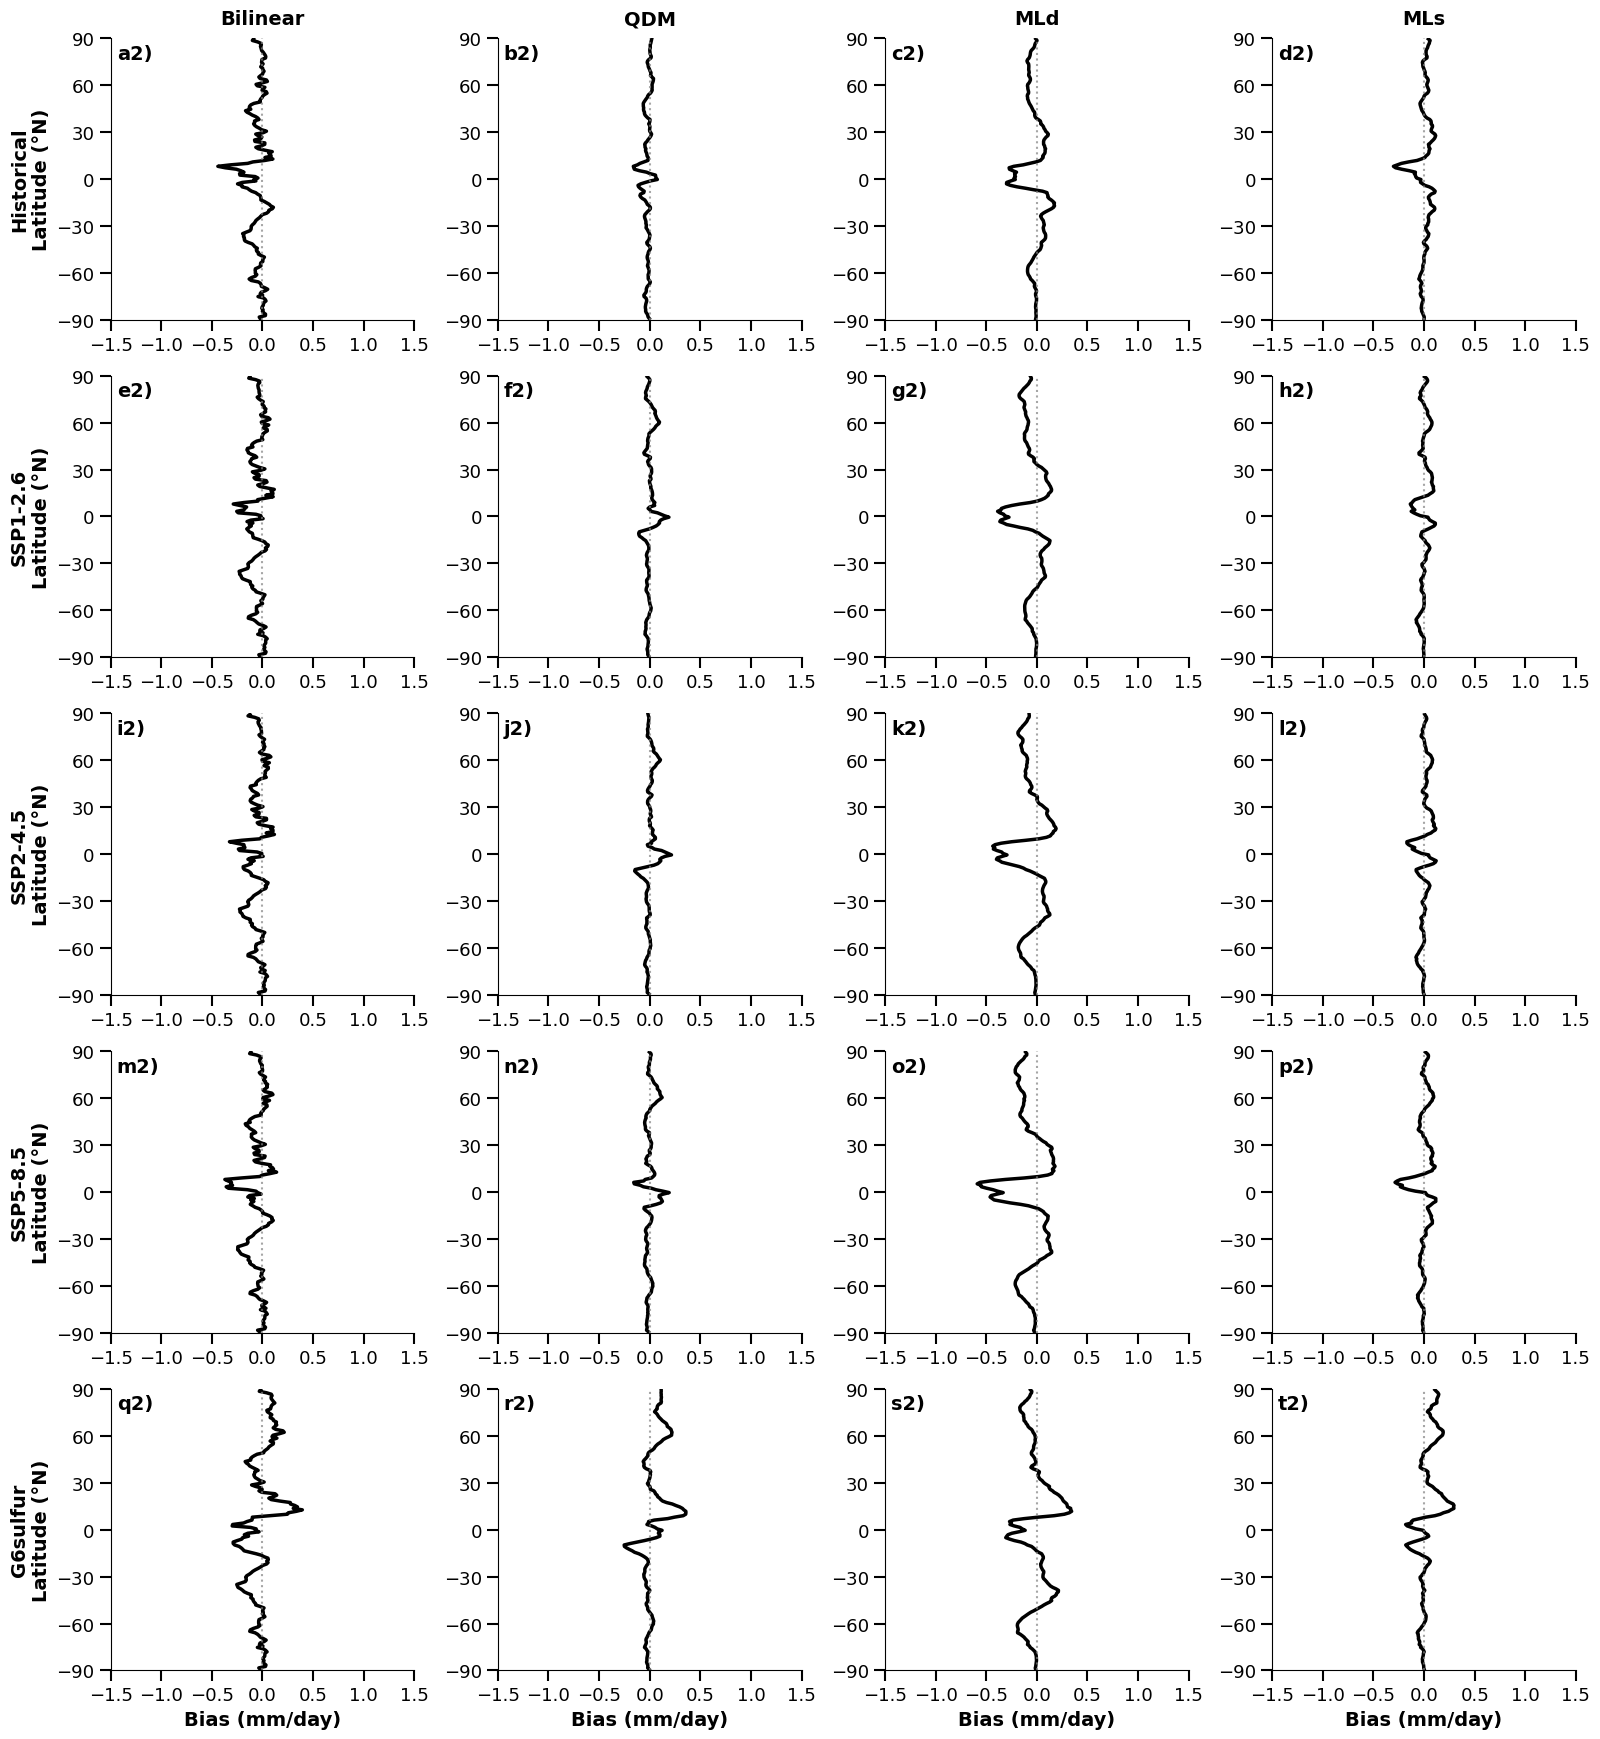

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
import warnings

# Suppress warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

# ----------------------------
# Configuration
# ----------------------------
results_dir = Path("../evaluation_results")
results_residual_dir = Path("../evaluation_results_residual")
figures_dir = Path("../Figures")

var_name = 'pr'  
scenarios = ['historical', 'ssp126', 'ssp245', 'ssp585', 'g6sulfur']  
scenario_labels = {
    'historical': 'Historical',  
    'ssp126': 'SSP1-2.6',
    'ssp245': 'SSP2-4.5',
    'ssp585': 'SSP5-8.5',
    'g6sulfur': 'G6sulfur'
}

# Model configuration
models = ['bilinear', 'qdm', 'mld', 'mls']
model_labels = {
    'bilinear': 'Bilinear',
    'qdm': 'QDM',
    'mld': 'MLd',
    'mls': 'MLs'
}

# ----------------------------
# Helper Functions
# ----------------------------
def calculate_mean_bias(pred_data, truth_data):
    """Calculate mean bias over all time steps."""
    bias = pred_data - truth_data
    mean_bias = np.mean(bias, axis=0)
    return mean_bias

def compute_zonal_mean_bias(bias_2d):
    """Compute zonal mean (longitude average)."""
    zonal_mean = np.nanmean(bias_2d, axis=1)
    return zonal_mean

# ----------------------------
# Load data and calculate biases
# ----------------------------
print("Loading data...")
biases = {scenario: {} for scenario in scenarios}
lat = None

for scenario in scenarios:
    # Load main results (for groundtruth, bilinear, MLd)
    main_file = results_dir / f"{var_name}_evaluation_{scenario}.nc"
    ds_main = xr.open_dataset(main_file)
    
    truth = ds_main['groundtruth'].values
    
    if lat is None:
        lat = ds_main.lat.values
    
    # Bilinear bias
    if 'input' in ds_main:
        biases[scenario]['bilinear'] = calculate_mean_bias(ds_main['input'].values, truth)
    
    # MLd bias (zscore_pixel)
    if 'pred_zscore_pixel' in ds_main:
        biases[scenario]['mld'] = calculate_mean_bias(ds_main['pred_zscore_pixel'].values, truth)
    
    ds_main.close()
    
    # Load QDM results
    qdm_file = results_dir / f"{var_name}_evaluation_{scenario}_qdm.nc"
    if qdm_file.exists():
        ds_qdm = xr.open_dataset(qdm_file)
        if 'pred_qdm' in ds_qdm:
            biases[scenario]['qdm'] = calculate_mean_bias(ds_qdm['pred_qdm'].values, truth)
        ds_qdm.close()
    
    # Load residual results (for MLs)
    residual_file = results_residual_dir / f"{var_name}_evaluation_{scenario}.nc"
    if residual_file.exists():
        ds_residual = xr.open_dataset(residual_file)
        if 'pred_grid' in ds_residual:
            biases[scenario]['mls'] = calculate_mean_bias(ds_residual['pred_grid'].values, truth)
        ds_residual.close()
    
    print(f"  Loaded {scenario}")

# ----------------------------
# Calculate zonal means
# ----------------------------
print("\nCalculating zonal mean biases...")
zonal_results = {scenario: {} for scenario in scenarios}

for scenario in scenarios:
    for model in models:
        zonal_results[scenario][model] = compute_zonal_mean_bias(biases[scenario][model])

# ----------------------------
# Check data range for setting appropriate x-axis limits
# ----------------------------
all_zonal = []
for scenario in scenarios:
    for model in models:
        all_zonal.append(zonal_results[scenario][model])
all_zonal_concat = np.concatenate(all_zonal)
print(f"\nZonal bias range: {np.nanmin(all_zonal_concat):.2f} to {np.nanmax(all_zonal_concat):.2f}")

# ----------------------------
# Create 5x4 subplot figure 
# ----------------------------
fig, axes = plt.subplots(5, 4, figsize=(16, 17.5))  

# X-axis limits for precipitation (adjust based on data range)
xlim = (-1.5, 1.5)  # Adjusted for precipitation (mm/day)
xticks = np.arange(-1.5, 1.6, 0.5)

for row_idx, scenario in enumerate(scenarios):
    for col_idx, model in enumerate(models):
        ax = axes[row_idx, col_idx]
        
        # Plot zonal mean bias (black solid line)
        ax.plot(zonal_results[scenario][model], lat, 
                color='black', linewidth=2.5, linestyle='-')
        
        # Add vertical line at x=0
        ax.axvline(x=0, color='gray', linestyle=':', linewidth=1.5, alpha=0.7)
        
        # Formatting
        ax.set_ylim(-90, 90)
        ax.set_yticks(np.arange(-90, 91, 30))
        ax.set_xlim(xlim)
        ax.set_xticks(xticks)
        
        ax.tick_params(axis='both', which='major', labelsize=13, 
                      length=8, width=1.5)
        
        # Labels
        if row_idx == 4:  # Bottom row (changed from 3)
            ax.set_xlabel('Bias (mm/day)', fontsize=14, fontweight='bold')  # Changed unit
        
        if col_idx == 0:  # Left column
            ax.set_ylabel('Latitude (°N)', fontsize=14, fontweight='bold')
        
        # Title for top row (model names)
        if row_idx == 0:
            ax.set_title(model_labels[model], fontsize=14, fontweight='bold', pad=10)
        
        # Scenario label on left side (first column only)
        if col_idx == 0:
            ax.text(-0.3, 0.5, scenario_labels[scenario], 
                   transform=ax.transAxes,
                   fontsize=14, fontweight='bold',
                   rotation=90, va='center', ha='center')
        
        # Add panel label - changed to use '2' suffix for precipitation
        panel_label = chr(97 + row_idx * 4 + col_idx) + '2)'
        ax.text(0.02, 0.98, panel_label, 
               transform=ax.transAxes,
               fontsize=14, fontweight='bold',
               verticalalignment='top')
        
        # Spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

plt.tight_layout()
output_file = figures_dir / "fig5_02.png"  
plt.savefig(output_file, dpi=300, bbox_inches='tight')
print(f"\nFigure saved to: {output_file}")
plt.show()